## Identifying Duplicate Questions

Over 100 million people visit Quora every month, so it's no surprise that many people ask similar (or the same) questions. Various questions with the same intent can cause people to spend extra time searching for the best answer to their question, and results in members answering multiple versions of the same question. Quora uses random forest to identify duplicated questions to provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
Follow the steps outlined below to build the appropriate classifier model. 


Steps:
- Download data
- Exploration
- Cleaning
- Feature Engineering
- Modeling

By the end of this project you should have **a presentation that describes the model you built** and its **performance**. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from tqdm import tqdm
from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brittanyharding/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/brittanyharding/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/brittanyharding/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
quora_questions = pd.read_csv("/Users/brittanyharding/LHL-Projects/mini-project-V/train.csv")

#### Note
There is no designated test.csv file. The train.csv file is the entire dataset. Part of the data in the train.csv file should be set aside to act as the final testing data.

### Exploration

In [3]:
# Display the first few rows of the dataset
quora_questions.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
#Check Shape
quora_questions.shape

(404290, 6)

In [5]:
quora_questions.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

Total number of unique questions: 537933
Number of questions that appear multiple times: 111780


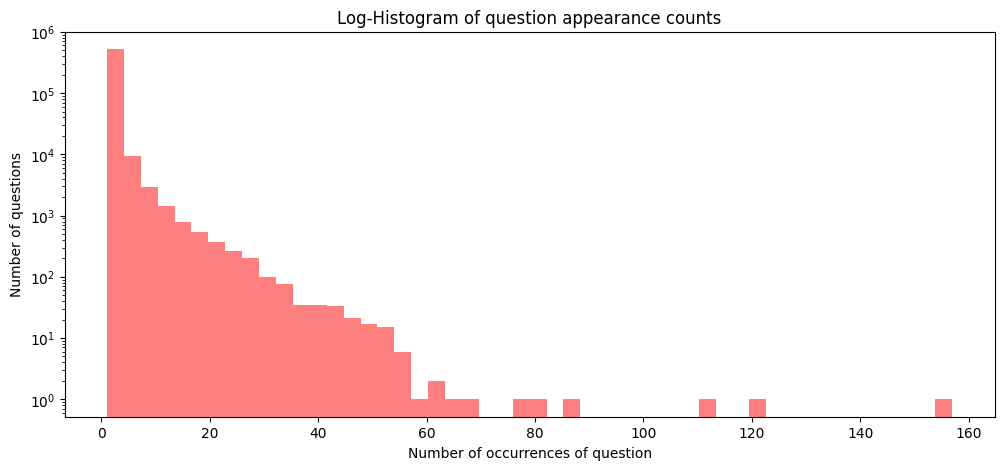

In [6]:
# Number of unique questions
unique_questions = pd.Series(quora_questions['qid1'].tolist() + quora_questions['qid2'].tolist())
print('Total number of unique questions:', len(np.unique(unique_questions)))

# Number of repeated questions
print('Number of questions that appear multiple times:', np.sum(unique_questions.value_counts() > 1))

# Histogram of question appearance counts
plt.figure(figsize=(12, 5))
plt.hist(unique_questions.value_counts(), bins=50, alpha=0.5, color= 'r', label='word in questions')
plt.yscale('log', nonpositive='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurrences of question')
plt.ylabel('Number of questions')
plt.show()

In [7]:
# Check for any null values
print("Number of null in question1: ", quora_questions['question1'].isnull().sum())
print("Number of null in question2: ", quora_questions['question2'].isnull().sum())

Number of null in question1:  1
Number of null in question2:  2


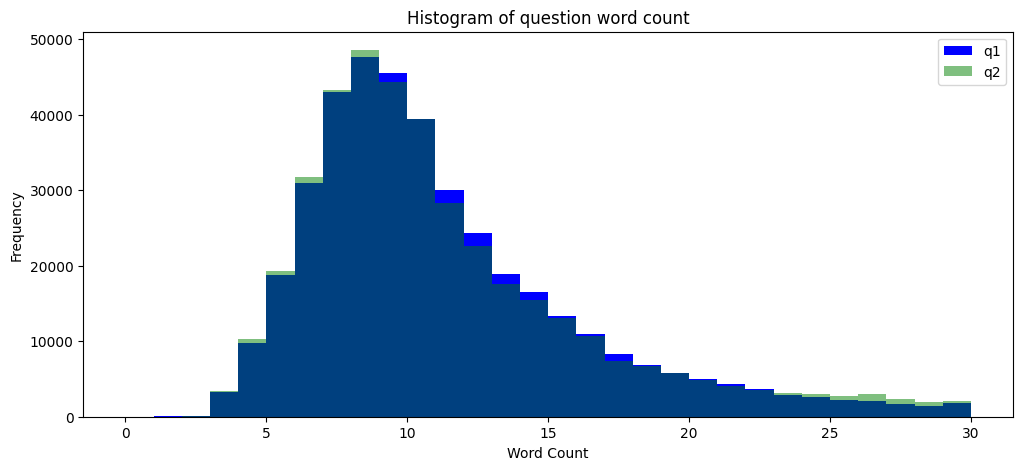

In [8]:
quora_questions['q1_len'] = quora_questions['question1'].str.len()
quora_questions['q2_len'] = quora_questions['question2'].str.len()

quora_questions['q1_word_count'] = quora_questions['question1'].apply(lambda x: len(str(x).split()))
quora_questions['q2_word_count'] = quora_questions['question2'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(12, 5))
plt.hist(quora_questions['q1_word_count'], bins=30, range=[0, 30], color='blue', label='q1')
plt.hist(quora_questions['q2_word_count'], bins=30, range=[0, 30], color='green', alpha=0.5, label='q2')
plt.title('Histogram of question word count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Class 0: 255027
Class 1: 149263
Proportion: 1.71 : 1


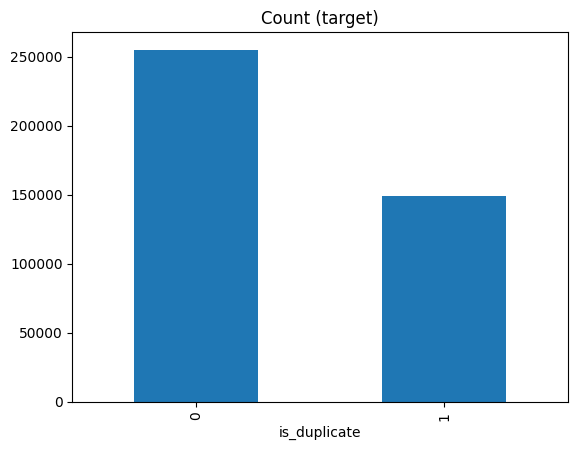

In [9]:
target_count = quora_questions['is_duplicate'].value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)')
plt.show()

### Cleaning

- Tokenization
- Stopwords cleaning
- Removing punctuation
- Normalizing
- Stemming

In [10]:
tqdm.pandas()

def preprocess_all(quora_questions, column):
    # Remove punctuation
    quora_questions[column] = quora_questions[column].progress_apply(lambda x: x.translate(str.maketrans("", "", string.punctuation)))
    
    # Convert to lowercase
    quora_questions[column] = quora_questions[column].progress_apply(lambda x: x.lower())
    
    # Tokenize the text
    quora_questions[column] = quora_questions[column].progress_apply(nltk.word_tokenize)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    quora_questions[column] = quora_questions[column].progress_apply(lambda x: [word for word in x if word not in stop_words])
    
    # Stem the tokens
    stemmer = PorterStemmer()
    quora_questions[column] = quora_questions[column].progress_apply(lambda x: [stemmer.stem(word) for word in x])
    
    # Join the tokens back into a single string
    quora_questions[column] = quora_questions[column].progress_apply(lambda x: ' '.join(x))
    
    return quora_questions

In [11]:
quora_questions = quora_questions.dropna(subset=['question1', 'question2'])
preprocess_all(quora_questions, 'question1')

100%|██████████| 404287/404287 [00:01<00:00, 280365.85it/s]


,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_word_count,q2_word_count
0,0,1,2,step step guid invest share market india,What is the step by step guide to invest in sh...,0,66.0,57.0,14,12
1,1,3,4,stori kohinoor kohinoor diamond,What would happen if the Indian government sto...,0,51.0,88.0,8,13
2,2,5,6,increas speed internet connect use vpn,How can Internet speed be increased by hacking...,0,73.0,59.0,14,10
3,3,7,8,mental lone solv,Find the remainder when [math]23^{24}[/math] i...,0,50.0,65.0,11,9
4,4,9,10,one dissolv water quikli sugar salt methan car...,Which fish would survive in salt water?,0,76.0,39.0,13,7
...,...,...,...,...,...,...,...,...,...,...
404285,404285,433578,379845,mani keyword racket program languag latest ver...,How many keywords are there in PERL Programmin...,0,85.0,79.0,14,13
404286,404286,18840,155606,believ life death,Is it true that there is life after death?,1,41.0,42.0,8,9
404287,404287,537928,537929,one coin,What's this coin?,0,17.0,17.0,4,3
404288,404288,537930,537931,approx annual cost live studi uic chicago indi...,I am having little hairfall problem but I want...,0,94.0,127.0,17,25


In [12]:
preprocess_all(quora_questions, 'question2')

100%|██████████| 404287/404287 [00:00<00:00, 414536.80it/s]


,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_word_count,q2_word_count
0,0,1,2,step step guid invest share market india,step step guid invest share market,0,66.0,57.0,14,12
1,1,3,4,stori kohinoor kohinoor diamond,would happen indian govern stole kohinoor kohi...,0,51.0,88.0,8,13
2,2,5,6,increas speed internet connect use vpn,internet speed increas hack dn,0,73.0,59.0,14,10
3,3,7,8,mental lone solv,find remaind math2324math divid 2423,0,50.0,65.0,11,9
4,4,9,10,one dissolv water quikli sugar salt methan car...,fish would surviv salt water,0,76.0,39.0,13,7
...,...,...,...,...,...,...,...,...,...,...
404285,404285,433578,379845,mani keyword racket program languag latest ver...,mani keyword perl program languag latest version,0,85.0,79.0,14,13
404286,404286,18840,155606,believ life death,true life death,1,41.0,42.0,8,9
404287,404287,537928,537929,one coin,what coin,0,17.0,17.0,4,3
404288,404288,537930,537931,approx annual cost live studi uic chicago indi...,littl hairfal problem want use hair style prod...,0,94.0,127.0,17,25


### Feature Engineering

- tf-idf
- word2vec
- word count
- number of the same words in both questions
- ....

### Modeling

Different modeling techniques can be used:

- logistic regression
- XGBoost
- LSTMs
- etc